# Using geoprocessing tools

In ArcGIS API for Python, geoprocessing toolboxes and tools within them are represented as Python module and functions within that module. To learn more about this organization, refer to the page titled [Accessing geoprocessing tools](/python/guide/accessing-geoprocessing-tools/).In this part of the guide, we will observe:

 - [Invoking geoprocessing tools](#invoking-geoprocessing-tools)
 - [Understanding tool input parameter and output return types](#understanding-tool-input-parameter-and-output-return-types)
   - [Using helper types](#using-helper-types)
   - [Using strings as input](#using-strings-as-input)
 - [Tools with multiple outputs](#tools-with-multiple-outputs)
   - [Invoking tools that create multiple outputs](#invoking-tools-that-create-multiple-outputs)
   - [Using named tuple to access multiple outputs](#using-named-tuple-to-access-multiple-outputs)
 - [Tools that export map image layer as output](#tools-that-export-map-image-layer-as-output)

<a id="invoking-geoprocessing-tools"></a>
## Invoking Geoprocessing Tools
You can execute a geoprocessing tool easily by importing its toolbox as a module and calling the function for the tool. Let us see how to execute the `extract_zion_data` tool from the Zion toolbox URL:

In [ ]:
# connect to ArcGIS Online
from arcgis.gis import GIS
from arcgis.geoprocessing import import_toolbox
gis = GIS()

# import the Zion toolbox
zion_toolbox_url = 'http://gis.ices.dk/gis/rest/services/Tools/ExtractZionData/GPServer'
zion = import_toolbox(zion_toolbox_url)

In [ ]:
result = zion.extract_zion_data()

Submitted.
Executing...


Thus, executing a geoprocessing tool is that simple. Let us learn a few more concepts that will help in using these tools efficiently.

<a id="understanding-tool-input-parameter-and-output-return-types"></a>
## Understanding tool input parameter and output return types

The functions for calling geoprocessing tools can accept and return built-in Python types such as str, int, bool, float, dicts, datetime.datetime as well as some helper types defined in the ArcGIS API for Python such as the following: 
* `arcgis.features.FeatureSet` - a set of features
* `arcgis.geoprocessing.LinearUnit` - linear distance with specified units
* `arcgis.geoprocessing.DataFile`  - a url or item id referencing data
* `arcgis.geoprocessing.RasterData` - url or item id and format of raster data

The tools can also accept lists of the above types.

**Note**: When the helper types are used an input, the function also accepts strings in their place. For example '5 Miles' can be passed as an input instead of LinearUnit(5, 'Miles') and a URL can be passed instead of a `DataFile` or `RasterData` input.

Some geoprocessing tools are configured to return an `arcgis.mapping.MapImageLayer` for visualizing the results of the tool. 

In all cases, the documentation of the tool function indicates the type of input parameters and the output values.

<a id="using-helper-types"></a>
### Using helper types

The helper types (`LinearUnit`, `DataFile` and `RasterData`) defined in the `arcgis.geoprocessing` module are simple classes that hold strings or URLs and have a dictionary representation.

The `extract_zion_data()` tool invoked above returns an output zip file as a `DataFile`:

In [ ]:
type(result)

arcgis.geoprocessing._types.DataFile

The output `Datafile` can be queried as shown in the snippet below.

In [ ]:
result

{"url": "http://gis.ices.dk/gis/rest/directories/arcgisjobs/tools/extractziondata_gpserver/j48b6f17abdf142679b11e3a71adcce8d/scratch/output.zip"}

The value types such as `DataFile` include helpful methods such as download:

In [ ]:
result.download()

'C:\\Users\\rohit\\AppData\\Local\\Temp\\output.zip'

<a id="using-strings-as-input"></a>
### Using strings as input

Strings can also be used as inputs in place of the helper types such as `LinearUnit`, `RasterData` and `DataFile`.

The example below calls the viewshed tool to compute and display the geographical area that is visible from a clicked location on the map. The function accepts an observation point as a `FeatureSet` and a viewshed distance as a `LinearUnit`, and returns a `FeatureSet`:

In [ ]:
viewshed = import_toolbox('http://sampleserver1.arcgisonline.com/ArcGIS/rest/services/Elevation/ESRI_Elevation_World/GPServer')

In [ ]:
help(viewshed.viewshed)

Help on function viewshed:

viewshed(input_observation_point:arcgis.features.feature.FeatureSet={'Fields': [{'name': 'FID', 'alias': 'FID', 'type': 'esriFieldTypeOID'}, {'name': 'Shape', 'alias': 'Shape', 'type': 'esriFieldTypeGeometry'}, {'name': 'OffsetA', 'alias': 'OffsetA', 'type': 'esriFieldTypeDouble'}], 'fields': [{'name': 'FID', 'alias': 'FID', 'type': 'esriFieldTypeOID'}, {'name': 'Shape', 'alias': 'Shape', 'type': 'esriFieldTypeGeometry'}, {'name': 'OffsetA', 'alias': 'OffsetA', 'type': 'esriFieldTypeDouble'}], 'geometryType': 'esriGeometryPoint', 'spatialReference': {'wkid': 54003}}, viewshed_distance:arcgis.geoprocessing._types.LinearUnit={'units': 'esriMeters', 'distance': 15000}, gis=None) -> arcgis.features.feature.FeatureSet
            
    
    
    Parameters:
    
       input_observation_point: Input Observation Point (FeatureSet). Required parameter. 
    
       viewshed_distance: Viewshed Distance (LinearUnit). Required parameter. 
    
            gis: Optional

In [ ]:
import arcgis
arcgis.env.out_spatial_reference = 4326

In [ ]:
map = gis.map('South San Francisco', zoomlevel=12)
map

![viewshed](http://esri.github.io/arcgis-python-api/notebooks/nbimages/guide_geoprocessing_using_gp_tools_01.PNG)

The code snippet below adds an event listener to the map, such that when clicked, `get_viewshed()` is called with the map widget and clicked point geometry as inputs. The event handler creates a `FeatureSet` from the clicked point geometry, and uses the string '5 Miles' as input for the viewshed_distance parameter instead of creating a `LinearUnit` object. These are passed into the viewshed function that returns the viewshed from the observation point. The map widget is able to draw the returned `FeatureSet` using its `draw()` method:

In [ ]:
from arcgis.features import Feature, FeatureSet

def get_viewshed(m, g):
    res = viewshed.viewshed(FeatureSet([Feature(g)]),"5 Miles") # "5 Miles" or LinearUnit(5, 'Miles') can be passed as input
    m.draw(res)
    
map.on_click(get_viewshed)

<a id="tools-with-multiple-outputs"></a>
## Tools with multiple outputs

Some Geoprocessing tools can return multiple results. For these tools, the corresponding function returns the multiple output values as a [named tuple](https://docs.python.org/3/library/collections.html#namedtuple-factory-function-for-tuples-with-named-fields). 

The example below uses a tool that returns multiple outputs:

In [ ]:
sandiego_toolbox_url = 'https://gis-public.co.san-diego.ca.us/arcgis/rest/services/InitialResearchPacketCSV_Phase2/GPServer'
multioutput_tbx = import_toolbox(sandiego_toolbox_url)

In [ ]:
help(multioutput_tbx.initial_research_packet_csv)

Help on function initial_research_packet_csv:

initial_research_packet_csv(apn_numbers:str='5980100200', project_number:str='PDS2012-3200-21193', project_title:str='PDS', gis=None) -> tuple
            
    Script for getting user's inputs and call python script to create data in term of CSV
    
    Parameters:
    
       apn_numbers: APN Numbers (str). Required parameter.  List of APNs seperated by comma.e.g.:1015300300e.g:102-690-07-00,1021809100,1021807700
    
       project_number: Project Number (str). Required parameter.  Project number
    
       project_title: Project Title (str). Required parameter.  Project Title
    
            gis: Optional, the GIS on which this tool runs. If not specified, the active GIS is used.
    
    
    Returns the following as a named tuple:
       report_output_csv_file - Report Output CSV File as a DataFile
       output_map_flags_file - Output Map Flags File as a DataFile
       soil_output_file - Soil Output File as a DataFile
       job_

<a id="invoking-tools-that-create-multiple-outputs"></a>
### Invoking tools that create multple outputs

The code snippet below shows how multiple outputs returned from a tool can be automatically unpacked by Python into multiple variables. Also, since we're not interested in the job status output, we can discard it using "_" as the variable name:

In [ ]:
report_output_csv_file, output_map_flags_file, soil_output_file, _ = multioutput_tbx.initial_research_packet_csv() 

Submitted.
Executing...


In [ ]:
report_output_csv_file

{"url": "http://gis-public.co.san-diego.ca.us/arcgis/rest/directories/arcgisjobs/initialresearchpacketcsv_phase2_gpserver/j4eb207e79c0c4f53875b56da9bb3f015/scratch/j4eb207e79c0c4f53875b56da9bb3f015_report.csv"}

In [ ]:
output_map_flags_file

{"url": "http://gis-public.co.san-diego.ca.us/arcgis/rest/directories/arcgisjobs/initialresearchpacketcsv_phase2_gpserver/j4eb207e79c0c4f53875b56da9bb3f015/scratch/j4eb207e79c0c4f53875b56da9bb3f015_mapflags.txt"}

In [ ]:
soil_output_file

{"url": "http://gis-public.co.san-diego.ca.us/arcgis/rest/directories/arcgisjobs/initialresearchpacketcsv_phase2_gpserver/j4eb207e79c0c4f53875b56da9bb3f015/scratch/j4eb207e79c0c4f53875b56da9bb3f015_soil.txt"}

<a id="using-named-tuple-to-access-multiple-outputs"></a>
### Using named tuple to access multiple tool  outputs
The code snippet below shows using a named tuple to access the multiple outputs returned from the tool:

In [ ]:
results = multioutput_tbx.initial_research_packet_csv()

Submitted.
Executing...


In [ ]:
results.report_output_csv_file

{"url": "http://gis-public.co.san-diego.ca.us/arcgis/rest/directories/arcgisjobs/initialresearchpacketcsv_phase2_gpserver/j38da5f0c5a5b4136b03a2d9d693bbc8d/scratch/j38da5f0c5a5b4136b03a2d9d693bbc8d_report.csv"}

In [ ]:
results.job_status

'Successfully created csv file'

<a id="tools-that-export-map-image-layer-as-output"></a>
## Tools that export MapImageLayer as output

Some Geoprocessing tools are configured to return their output as MapImageLayer for easier visualization of the results. The resultant layer can be added to a map or queried.

An example of such a tool is below:

In [ ]:
hotspots = import_toolbox('https://sampleserver6.arcgisonline.com/arcgis/rest/services/911CallsHotspot/GPServer')

In [ ]:
help(hotspots.execute_911_calls_hotspot)

Help on function execute_911_calls_hotspot:

execute_911_calls_hotspot(query:str='("DATE" > date \'1998-01-01 00:00:00\' AND "DATE" < date \'1998-01-31 00:00:00\') AND ("Day" = \'SUN\' OR "Day"= \'SAT\')', gis=None) -> tuple
            
    The tool filters 911 calls based on the query provided by the client and creates a hotspot raster based on the frequency of calls. The hotspot raster is created using the Spatial Statistics Hot Spot Analysis tool, which uses the Getis‐Ord Gi* algorithm. The Hotspots represent statistically significant spatialclusters of high and low 911 emergency calls in the study area. The red regions in the raster indicates high frequency and the blue regions represent low frequency of calls.
    
    Parameters:
    
       query: Query (str). Required parameter.  A SQL query string to filter calls. The query can be based on the day of the week such as SUN/MON/TUE/WED/THU/FRI/SAT (Field Name: Day) or a date range between Jan 1st ,1998 to May 31, 1998 (Field Nam

In [ ]:
result_layer, output_features, hotspot_raster = hotspots.execute_911_calls_hotspot()

Submitted.
Executing...


In [ ]:
result_layer

<MapImageLayer url:"https://sampleserver6.arcgisonline.com/arcgis/rest/services/911CallsHotspot/MapServer/jobs/je7c507da0a2e45f796a170348248b4dc">

In [ ]:
hotspot_raster

{'mapImage': {'extent': {'spatialReference': {'latestWkid': 102726,
    'wkid': 102726},
   'xmax': 7628948.291202795,
   'xmin': 7586498.220384206,
   'ymax': 687779.355638728,
   'ymin': 645329.284820139},
  'height': 400,
  'href': 'https://sampleserver6.arcgisonline.com/arcgis/rest/directories/arcgisoutput/911CallsHotspot_GPServer/911CallsHotspot_MapServer/_ags_map65dac050231e4acaa56e205d00f922fe.png',
  'scale': 122256.20395753652,
  'width': 400}}

The resultant hotspot raster can be visualized in the Jupyter Notebook using the code snippet below:

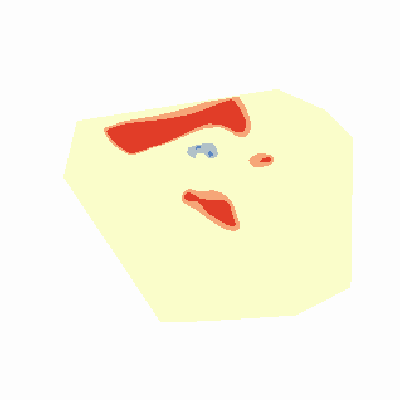

In [ ]:
from IPython.display import Image
Image(hotspot_raster['mapImage']['href'])